In [2]:
import os
import shutil
import cv2
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Flatten

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


50% training %50testing

Lo hemos repartido asi, ya que en el conjunto de datos solo teniamos dos ejemplos para cada clase, y uno lo necesitabamos para el testing

In [6]:
input_dir = "Elegidos"
output_dir = "Elegidos_test"
if not os.path.exists(output_dir):
        os.makedirs(output_dir)
for file_name in os.listdir(input_dir):
    if file_name.endswith('.png'):
        # Extrae información del nombre del archivo
        parts = file_name.split('_')
        numero = parts[1]
        
        if numero == "1":
            src_path = os.path.join(input_dir, file_name)
            dest_path = os.path.join(output_dir, file_name)
            shutil.move(src_path, dest_path)

Cargar las imagenes, y guardar cada secuencia correctamente con su nombre en Class_data{}, que es de donde vamos a partir para que los fragmentos del mismo video se tengan en cuenta como fragmentos. El Class_data{} tiene que estar actualizado para cada cambio que se hace 

In [14]:
img_width, img_height = 240, 240

# Define una función para cargar y preprocesar una imagen
def load_and_preprocess_image(file_path):
    img = load_img(file_path, target_size=(img_width, img_height))
  
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalizar valores de píxeles
    return img_array

data_dir = 'Elegidos_test'
data = {}

# Itera sobre los archivos en el directorio de datos
for file_name in os.listdir(data_dir):
    if file_name.endswith('.png'):
        # Extrae información del nombre del archivo
        parts = file_name.split('_')
        gesto = parts[0]  # Obtiene el gesto (por ejemplo, 'abanico')
        numero = parts[1]  # Obtiene el número de la secuencia (por ejemplo, '1')
        frame = parts[2].split('.')[0]  # Obtiene el número del frame (por ejemplo, '33')

        key = gesto + '_' + numero  # Clave de la secuencia (por ejemplo, 'abanico_1')

        # Carga y preprocesa la imagen
        file_path = os.path.join(data_dir, file_name)
        img_array = load_and_preprocess_image(file_path)

        # Almacena los datos de la imagen y la etiqueta en el diccionario
        if key not in data:
            data[key] = {'frames': [], 'label': f'{gesto}_{numero}'}
        data[key]['frames'].append((file_path, img_array))

# Agrupa las secuencias por clase (gesto)
class_data = {}
for key, value in data.items():
    gesto_numero = value['label']  # Etiqueta de la secuencia (por ejemplo, 'abanico_1')
    gesto = gesto_numero.split('_')[0]  # Obtiene solo el gesto (por ejemplo, 'abanico')
    if gesto not in class_data:
        class_data[gesto] = []
    class_data[gesto].append((key, value['frames']))

# Verifica la estructura final de class_data
for gesto, sequences in class_data.items():
    print(f'Gesto: {gesto}')
    for sequence in sequences:
        key, frames = sequence
        print(f'  Secuencia: {key}, Número de frames: {len(frames)}')


Gesto: abrelatas
  Secuencia: abrelatas_101, Número de frames: 10
  Secuencia: abrelatas_102, Número de frames: 10
  Secuencia: abrelatas_103, Número de frames: 10
  Secuencia: abrelatas_104, Número de frames: 10
  Secuencia: abrelatas_105, Número de frames: 10
  Secuencia: abrelatas_106, Número de frames: 10
  Secuencia: abrelatas_107, Número de frames: 10
  Secuencia: abrelatas_108, Número de frames: 10
  Secuencia: abrelatas_109, Número de frames: 10
  Secuencia: abrelatas_10, Número de frames: 10
  Secuencia: abrelatas_110, Número de frames: 10
  Secuencia: abrelatas_111, Número de frames: 10
  Secuencia: abrelatas_112, Número de frames: 10
  Secuencia: abrelatas_113, Número de frames: 10
  Secuencia: abrelatas_114, Número de frames: 10
  Secuencia: abrelatas_115, Número de frames: 10
  Secuencia: abrelatas_116, Número de frames: 10
  Secuencia: abrelatas_117, Número de frames: 10
  Secuencia: abrelatas_118, Número de frames: 10
  Secuencia: abrelatas_119, Número de frames: 10
  Se

Este codigo, crear un imagen espejo para cada uno de ellos, es decir los cambia de posición horizontalmente.

In [7]:
for sequence_name, sequence_frames in class_data.items():
    for key, frames in sequence_frames:
            for frame_path, frame_array in frames:
                frame_array = (frame_array * 255).astype(np.uint8)
                flipped = tf.image.flip_left_right(frame_array)
                flipped = flipped.numpy() 
                output_filename = os.path.basename(frame_path)
                parts = output_filename.split('_')
                gesto = parts[0]
                numero = parts[1]
                frame = parts[2]
                new_filename = f"{gesto}_3_{frame}_mirror.png"
                output_path = os.path.join("Elegidos_test", new_filename)
                cv2.imwrite(output_path, flipped)

Este codigo hace 50 data augmentation de las sequencias originales y otras 50 de las que son el espejo de ellas.

In [13]:
# Función para aplicar aumentos de datos a una imagen
def augment_image(image, angle, tx, ty):
    rows, cols = image.shape[:2]

    # Rotación
    M_rot = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated_image = cv2.warpAffine(image, M_rot, (cols, rows), borderMode=cv2.BORDER_CONSTANT)

    # Traslación
    M_trans = np.float32([[1, 0, tx], [0, 1, ty]])
    translated_image = cv2.warpAffine(rotated_image, M_trans, (cols, rows), borderMode=cv2.BORDER_CONSTANT)

    return translated_image

# Directorio de entrada y salida
input_directory = 'Elegidos_test'
output_directory = 'Elegidos_augmented'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Parámetros de aumentos de datos
angle_range = (-20, 20)  # Rango de ángulos de rotación en grados
translation_range = (-0.2, 0.2)  # Rango de traslación como fracción de la dimensión de la imagen

for i in range(50):
    # Generar aumentos de datos
    for sequence_name, sequence_frames in class_data.items():
        # Generar transformaciones aleatorias para esta secuencia
        angle = random.uniform(angle_range[0], angle_range[1])
        tx = random.uniform(translation_range[0], translation_range[1])
        ty = random.uniform(translation_range[0], translation_range[1])

        # Aplicar las mismas transformaciones a todas las imágenes de la secuencia
        for key, frames in sequence_frames:
            for frame_path, frame_array in frames:
                # Asegúrate de convertir de nuevo la imagen al formato original antes de guardar
                frame_array = (frame_array * 255).astype(np.uint8)
                augmented_frame = augment_image(frame_array, angle, tx * frame_array.shape[1], ty * frame_array.shape[0])

                # Cambiar el nombre del archivo de salida
                output_filename = os.path.basename(frame_path)
                parts = output_filename.split('_')
                gesto = parts[0]
                numero = parts[1]
                frame = parts[2]
                tipo = parts[3]
                
                if tipo == "mirror.png":
                    new_filename = f"{gesto}_{int(numero)+ i + 5}_{frame}_aug_{i}.png"
                    # Guardar la imagen aumentada en el directorio de salida
                    output_path = os.path.join(output_directory, new_filename)
                    cv2.imwrite(output_path, augmented_frame)

                else:
                    new_filename = f"{gesto}_{int(numero)+ i + 100}_{frame}_aug_{i}.png"
                    # Guardar la imagen aumentada en el directorio de salida
                    output_path = os.path.join(output_directory, new_filename)
                    cv2.imwrite(output_path, augmented_frame)



print("Data augmentation completed.")


Data augmentation completed.


Todo estos son para los pasos que he ido haciendo para que tenga cada secuencia en las carpetas correspondientes.

In [5]:
# Directorios de entrada y salida
input_dir = 'Elegidos'
output_dir = 'Elegidos_test'

# Crear directorio de salida si no existe
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Listar los archivos en el directorio de entrada
file_list = sorted(os.listdir(input_dir))

# Iterar sobre los archivos y mover los que están en las posiciones impares
for idx, file_name in enumerate(file_list):
    if file_name.endswith('.png') and idx % 2 == 0:  # idx % 2 == 0 selecciona los índices impares (0, 2, 4, ...)
        src_path = os.path.join(input_dir, file_name)
        dest_path = os.path.join(output_dir, file_name)
        shutil.move(src_path, dest_path)


In [26]:
input_dir = "Elegidos"
output_dir = "Elegidos2"

# Itera sobre los archivos en el directorio de datos
for file_name in os.listdir(input_dir):
    if file_name.endswith('.png'):
        # Extrae información del nombre del archivo
        parts = file_name.split('_')
       
        numero = parts[1]
        a = parts[2]

        # if not os.path.exists(output_dir):
        #         os.makedirs(output_dir)
                
        # if numero == "2":
        #     src_path = os.path.join(input_dir, file_name)
        #     dest_path = os.path.join(output_dir, file_name)
            
        #     shutil.move(src_path, dest_path)
       
        # Verifica que haya suficientes partes en el nombre del archivo
        # if len(parts) >= 4:
        #     new_file_name = f"{parts[0]}_{parts[1]}_{parts[3]}.png"

        #     # Ruta completa del archivo original y nuevo archivo
        #     src_path = os.path.join(input_dir, file_name)
        #     dest_path = os.path.join(output_dir, new_file_name)
            
        #     # Renombra y mueve el archivo
        #     os.rename(src_path, dest_path)
        if numero == "3":
            src_path = os.path.join(input_dir, file_name)
            # dest_path = os.path.join(output_dir, file_name)
            # shutil.move(src_path, dest_path)
            os.remove(src_path)
            

       


Aqui es ya donde creamos el modelo, para ello utilizamos los datos que tenemos en Class_data{} y entrena con los datos aumentados el LSTM que hemos creado. Mostrando asi las graficas de acierto y perdida.

abrelatas
acampada
accidente
acelga
ajedrez
armario
asterisco
botella


c:\Users\garme\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.2165 - loss: 2.0807 - val_accuracy: 0.3780 - val_loss: 1.8699
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.7162 - loss: 1.4608 - val_accuracy: 0.5122 - val_loss: 1.6173
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9103 - loss: 0.8877 - val_accuracy: 0.5976 - val_loss: 1.3029
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.9724 - loss: 0.4205 - val_accuracy: 0.6159 - val_loss: 1.2539
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.9975 - loss: 0.1645 - val_accuracy: 0.6402 - val_loss: 1.2084
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 1.0000 - loss: 0.0790 - val_accuracy: 0.6341 - val_loss: 1.1419
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 1.0000 - loss: 0.0425 - val_accuracy: 0.6341 - val_loss: 1.2388
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 1.0000 - loss: 0.0289 - val_accuracy: 0.6159 - val_loss

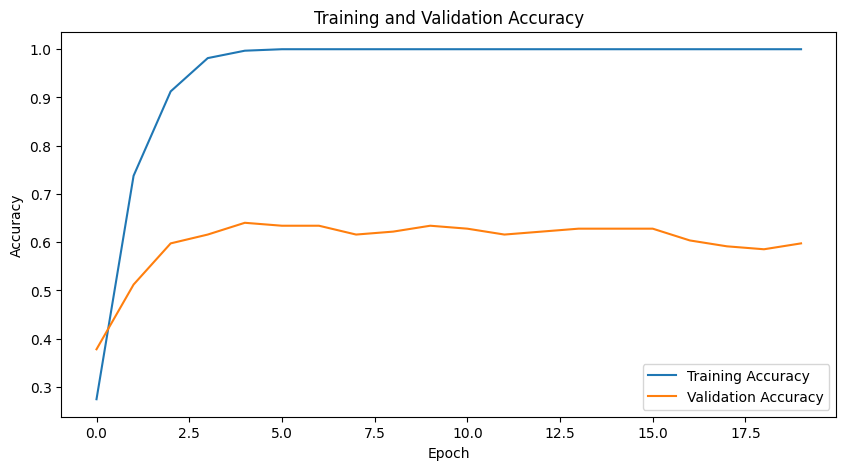

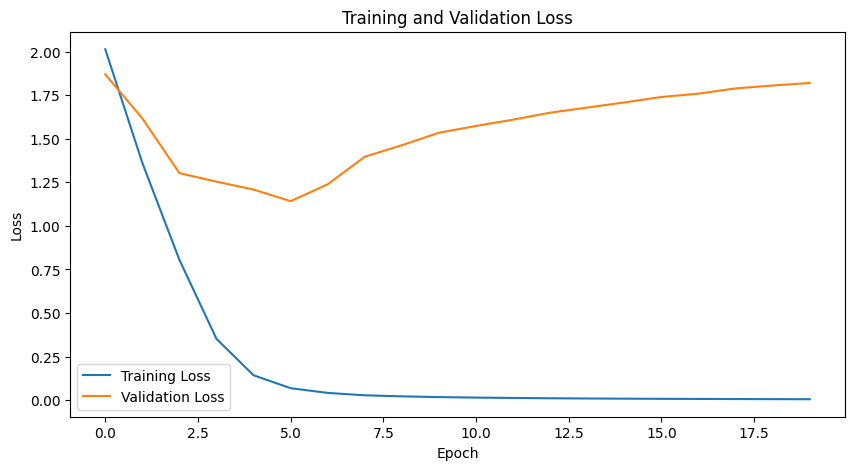

In [15]:
# Crea listas de secuencias y etiquetas
X = []
y = []
for gesto, sequences in class_data.items():
    print(gesto)
    for sequence in sequences:
    
        key, frames = sequence
 
        img_sequence = [img_array for file_path, img_array in frames]
        X.append(img_sequence)
        y.append(gesto)

# Convierte las etiquetas a codificación one-hot

label_encoder = LabelEncoder()
etiquetas_codificadas = label_encoder.fit_transform(y)

# Número de clases debe ser igual al número de clases únicas en etiquetas codificadas
num_classes = len(set(etiquetas_codificadas))

y = to_categorical(etiquetas_codificadas, num_classes=num_classes)


# Calcula la longitud máxima de las secuencias
max_len = max(len(seq) for seq in X)
# Encuentra la forma de las imágenes



# Rellena las secuencias con ceros al principio
X_padded = pad_sequences(X, maxlen=max_len, padding='pre', dtype='float32')

# Divide los datos en conjuntos de entrenamiento y validación (85%-15%)
X_train, X_val, y_train, y_val = train_test_split(X_padded, y, test_size=0.20, random_state=42)

# Función para crear el modelo
def create_model():
    model = Sequential()
    model.add(TimeDistributed(Flatten(), input_shape=(max_len, img_width, img_height, 3)))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Crear el modelo
model = create_model()

# Entrenar el modelo y guardar el historial
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Graficar los resultados
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Una vez entrenado el modelo, preparamos los datos de prueba y evaluamos el modelo.

In [16]:
# Define la ruta al directorio de test
test_dir = 'Elegidos'

# Crea un diccionario para almacenar las secuencias de test agrupadas por clase (gesto)
test_data = {}

# Itera sobre los archivos en el directorio de test
for file_name in os.listdir(test_dir):
    if file_name.endswith('.png'):
        # Extrae información del nombre del archivo
        parts = file_name.split('_')
        gesto = parts[0]  # Obtiene el nombre del gesto
        numero = parts[1]  # Ignora el número de la secuencia por ahora

        key = gesto  # La clave será el nombre del gesto

        # Carga y preprocesa la imagen
        file_path = os.path.join(test_dir, file_name)
        img_array = load_and_preprocess_image(file_path)

        # Almacena la imagen en la lista asociada al gesto
        if key not in test_data:
            test_data[key] = []  # Inicializa la lista si es la primera vez que se encuentra este gesto
        test_data[key].append(img_array)

# Convierte las secuencias de test a una  lista de listas
X_test = list(test_data.values())

# Crea las etiquetas para las secuencias de test
y_test = list(test_data.keys())

# Convierte las etiquetas de test a codificación one-hot
etiquetas_codificadas_test = label_encoder.transform(y_test)
y_test = to_categorical(etiquetas_codificadas_test, num_classes=num_classes)

# Calcula la longitud máxima de las secuencias de test
max_len_test = max(len(seq) for seq in X_test)

# Rellena las secuencias de test con ceros al principio
X_test_padded = pad_sequences(X_test, maxlen=max_len, padding='pre', dtype='float32')

# Evaluar el modelo en el conjunto de test
test_loss, test_acc = model.evaluate(X_test_padded, y_test, verbose=0)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}')


Test loss: 3.9550, Test accuracy: 0.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step    


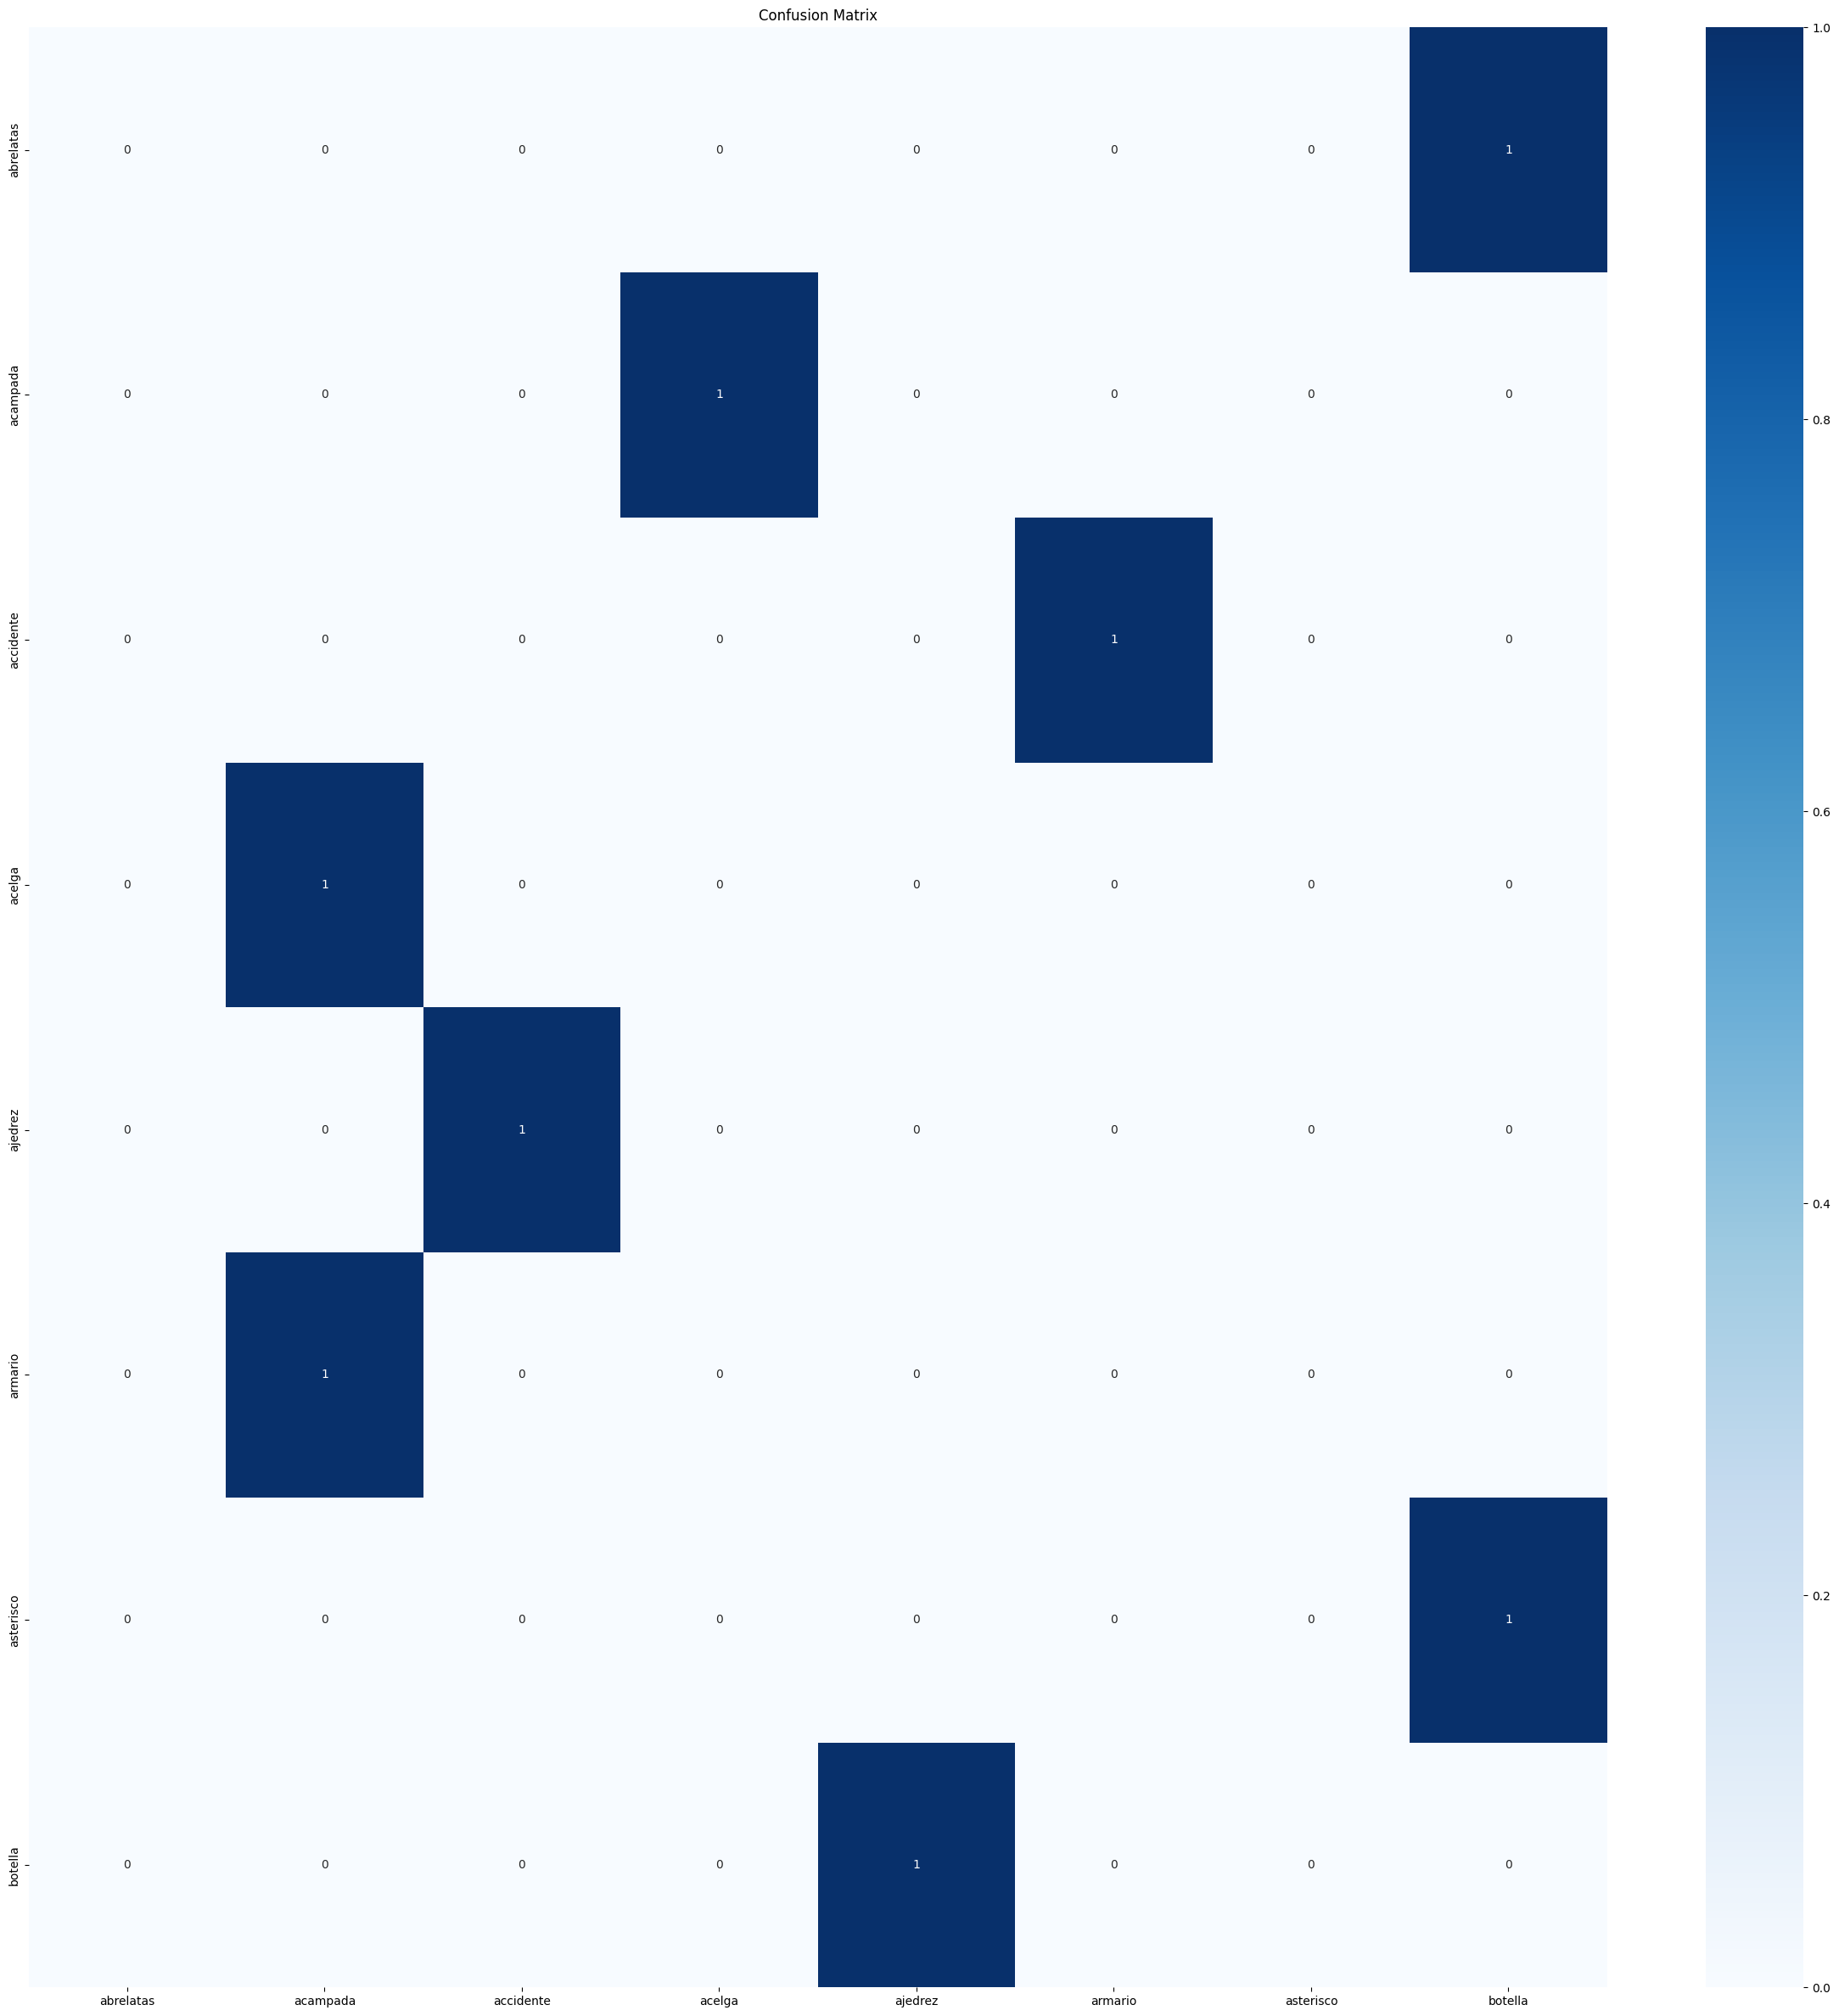

In [17]:
# Obtener las predicciones del modelo
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generar la matriz de confusión
cm = confusion_matrix(np.argmax(y_test, axis =1), y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Visualizar la matriz de confusión
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.show()